In [58]:
# installs
! pip install spacy
! pip install nltk
! pip install scikit-plot
! pip install umap-learn
! pip install afinn
! pip install textblob
! pip install seaborn
! pip install gensim
! pip install langdetect


In [59]:
import datetime 
from dateutil.relativedelta import *
import os
import re 
import string
import nltk
import pandas as pd 
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=stopwords.words('english')
import nltk
nltk.download('wordnet')

import matplotlib.pyplot as plt 

from collections import OrderedDict
import langdetect 
from langdetect import DetectorFactory , detect_langs # for dermining language  
DetectorFactory.seed = 0

#from google_trans_new import google_translator  # translating words
#translator = google_translator()  

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation


from wordcloud import WordCloud 
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Import

In [60]:
csv = pd.read_csv("https://raw.githubusercontent.com/kennyzhou9/Capstone-Project-Team19/main/Groupon_BJs.csv")
bjs = pd.DataFrame(csv)
bjs.head()

,name,text,rating,review_count,top_reviewer,helpful_reviewer,date_published,date_scraped
0,Ellen,I’ve always appreciated BJ’s and shopped at a ...,3,2,0,0,03/20/2021,04/07/2021 13:09:03
1,Heather,Glad I got this. I went there today and got so...,5,28,1,1,03/17/2021,04/07/2021 13:09:03
2,Juliette,Couldn’t print out a physical card and gave me...,1,9,1,0,02/24/2021,04/07/2021 13:09:03
3,Erika,"It was very easy, you just show them the barco...",5,1,0,0,02/04/2021,04/07/2021 13:09:03
4,Linda,"Is a great place for shopping for everyone, es...",5,1,0,0,02/03/2021,04/07/2021 13:09:03


In [61]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

In [62]:
DetectorFactory.seed = 0

In [63]:
languages = []


for ii in tqdm(range(0,len(bjs))):
    # split by space into list, take the first x intex, join with space
    text = bjs.iloc[ii]['text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        
        except Exception as e:
           lang = "unknown"
                
            
           
    
      
    languages.append(lang)

100%|██████████| 5375/5375 [00:37<00:00, 143.49it/s]


# Tokenization

In [64]:
# Package import
import string
import spacy.cli 
from spacy.lang.en import English
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')
import en_core_web_sm
from  spacy.lang.en.stop_words import STOP_WORDS
parser = English()
punctuations = string.punctuation

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [65]:
bjs

,name,text,rating,review_count,top_reviewer,helpful_reviewer,date_published,date_scraped
0,Ellen,I’ve always appreciated BJ’s and shopped at a ...,3,2,0,0,03/20/2021,04/07/2021 13:09:03
1,Heather,Glad I got this. I went there today and got so...,5,28,1,1,03/17/2021,04/07/2021 13:09:03
2,Juliette,Couldn’t print out a physical card and gave me...,1,9,1,0,02/24/2021,04/07/2021 13:09:03
3,Erika,"It was very easy, you just show them the barco...",5,1,0,0,02/04/2021,04/07/2021 13:09:03
4,Linda,"Is a great place for shopping for everyone, es...",5,1,0,0,02/03/2021,04/07/2021 13:09:03
...,...,...,...,...,...,...,...,...
5370,Angela,Can double coupons here compared to other,5,0,1,0,08/24/2013,04/07/2021 13:43:11
5371,Trenny,Best groupon yet!,5,0,1,0,08/23/2013,04/07/2021 13:43:11
5372,Jeremy,This was a great deal and everyone needs to ta...,5,0,0,0,08/23/2013,04/07/2021 13:43:11
5373,Gladys,Good deal.,5,0,0,0,08/22/2013,04/07/2021 13:43:11


In [66]:
#Tokenization
bjs['token'] =bjs['text'].apply(lambda x:nlp(x))
spacy_token = bjs.token

In [67]:
stopwords = list(STOP_WORDS)

In [68]:
def my_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [69]:
# Remove stopwords
bjs['without_stopwords'] = bjs['text'].apply(my_tokenizer).agg(lambda x: ','.join(map(str,x)))
bjs.without_stopwords

0       appreciated,bj,shopped,bj,lived,new,york,bj,wa...
1                        glad,got,went,today,got,bargains
2       print,physical,card,gave,non,working,membershi...
3                                 easy,barcode,hand,cards
4       great,place,shopping,especially,big,family,ben...
                              ...                        
5370                              double,coupons,compared
5371                                         best,groupon
5372                           great,deal,needs,advantage
5373                                            good,deal
5374    customer,service,sucked,store,phone,went,locat...
Name: without_stopwords, Length: 5375, dtype: object

### Lemmatization

In [70]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')


def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
# Lemmatizing
bjs['Lemmatize'] = bjs['without_stopwords'].apply(lambda x: lemmatize_sentence(x))
bjs.Lemmatize

0       appreciate , bj , shop , bj , live , new , yor...
1                 glad , get , go , today , get , bargain
2       print , physical , card , give , non , work , ...
3                            easy , barcode , hand , card
4       great , place , shopping , especially , big , ...
                              ...                        
5370                            double , coupon , compare
5371                                       best , groupon
5372                      great , deal , need , advantage
5373                                          good , deal
5374    customer , service , suck , store , phone , go...
Name: Lemmatize, Length: 5375, dtype: object

In [72]:
bjs.head()

,name,text,rating,review_count,top_reviewer,helpful_reviewer,date_published,date_scraped,token,without_stopwords,Lemmatize
0,Ellen,I’ve always appreciated BJ’s and shopped at a ...,3,2,0,0,03/20/2021,04/07/2021 13:09:03,"(I, ’ve, always, appreciated, BJ, ’s, and, sho...","appreciated,bj,shopped,bj,lived,new,york,bj,wa...","appreciate , bj , shop , bj , live , new , yor..."
1,Heather,Glad I got this. I went there today and got so...,5,28,1,1,03/17/2021,04/07/2021 13:09:03,"(Glad, I, got, this, ., I, went, there, today,...","glad,got,went,today,got,bargains","glad , get , go , today , get , bargain"
2,Juliette,Couldn’t print out a physical card and gave me...,1,9,1,0,02/24/2021,04/07/2021 13:09:03,"(Could, n’t, print, out, a, physical, card, an...","print,physical,card,gave,non,working,membershi...","print , physical , card , give , non , work , ..."
3,Erika,"It was very easy, you just show them the barco...",5,1,0,0,02/04/2021,04/07/2021 13:09:03,"(It, was, very, easy, ,, you, just, show, them...","easy,barcode,hand,cards","easy , barcode , hand , card"
4,Linda,"Is a great place for shopping for everyone, es...",5,1,0,0,02/03/2021,04/07/2021 13:09:03,"(Is, a, great, place, for, shopping, for, ever...","great,place,shopping,especially,big,family,ben...","great , place , shopping , especially , big , ..."


# Vectorization

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [74]:
text = bjs['without_stopwords'].values
max_features = 2**12

X = vectorize(text, max_features)

# Reduce Dimensionality by applying T-SNE

In [75]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50,random_state=123)  
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5375 samples in 4.053s...
[t-SNE] Computed neighbors for 5375 samples in 245.493s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5375
[t-SNE] Computed conditional probabilities for sample 2000 / 5375
[t-SNE] Computed conditional probabilities for sample 3000 / 5375
[t-SNE] Computed conditional probabilities for sample 4000 / 5375
[t-SNE] Computed conditional probabilities for sample 5000 / 5375
[t-SNE] Computed conditional probabilities for sample 5375 / 5375
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 138.992615
[t-SNE] KL divergence after 1000 iterations: 3.122034


In [76]:
X_embedded

array([[ 24.288864  ,  21.290134  ],
       [ 10.048629  ,  -0.32304925],
       [  3.8315222 ,  -4.827716  ],
       ...,
       [ 17.938564  ,  19.018848  ],
       [ -5.8459997 , -15.009878  ],
       [  1.979029  , -23.261702  ]], dtype=float32)

# Determining Clusters

### Elbow method

In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

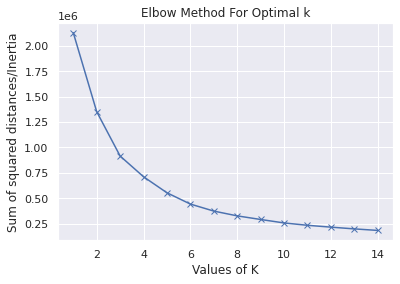

In [78]:
ss_distance = []
K = range (1,15)
for num_cluster in K:
  kmeans = KMeans(n_clusters=num_cluster)
  kmeans.fit(X_embedded)
  ss_distance.append(kmeans.inertia_)
plt.plot(K,ss_distance,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

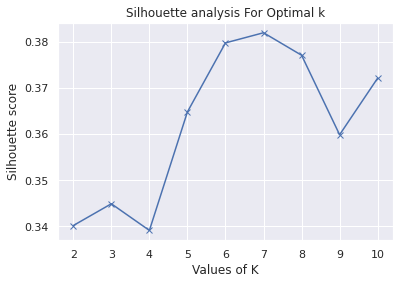

In [79]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X_embedded)
  cluster_labels = kmeans.labels_
 # silhouette score
  silhouette_avg.append(silhouette_score(X_embedded, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [80]:
# Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_embedded)

In [81]:
# KMeans Clustering
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_embedded)


In [82]:
len(X_embedded)

5375

In [83]:
bjs['clusters'] = y_pred

In [84]:
bjs.loc[bjs['clusters']==5]
#将这些clusters当作 tiam的 rating来进行 topic modelling，然后再在scatterplot中label上相应的名称即可

,name,text,rating,review_count,top_reviewer,helpful_reviewer,date_published,date_scraped,token,without_stopwords,Lemmatize,clusters
0,Ellen,I’ve always appreciated BJ’s and shopped at a ...,3,2,0,0,03/20/2021,04/07/2021 13:09:03,"(I, ’ve, always, appreciated, BJ, ’s, and, sho...","appreciated,bj,shopped,bj,lived,new,york,bj,wa...","appreciate , bj , shop , bj , live , new , yor...",5
72,Angel,"Very easy to redeem, nice store. Great deals, ...",5,0,0,0,12/02/2020,04/07/2021 13:09:30,"(Very, easy, to, redeem, ,, nice, store, ., Gr...","easy,redeem,nice,store,great,deals,money,spent","easy , redeem , nice , store , great , deal , ...",5
107,Karlene,I have used this coupon for the last 4 years. ...,5,0,1,0,11/29/2020,04/07/2021 13:09:41,"(I, have, used, this, coupon, for, the, last, ...","coupon,4,years,best","coupon,4 , year , best",5
135,Kimberly,"It was easy to sign up, the clerk was friendly...",5,0,1,1,11/26/2020,04/07/2021 13:09:54,"(It, was, easy, to, sign, up, ,, the, clerk, w...","easy,sign,clerk,friendly,helpful,need,groupon,...","easy , sign , clerk , friendly , helpful , nee...",5
149,Robert,So far very Happy,5,0,1,1,11/24/2020,04/07/2021 13:09:59,"(So, far, very, Happy)","far,happy","far , happy",5
...,...,...,...,...,...,...,...,...,...,...,...,...
5355,Jonathan,Do not email me.,5,0,0,0,09/05/2013,04/07/2021 13:43:04,"(Do, not, email, me, .)",email,email,5
5367,Stacy,We love BJ's. they have more brands that we us...,5,0,0,0,08/25/2013,04/07/2021 13:43:07,"(We, love, BJ, 's, ., they, have, more, brands...","love,bj,brands,use,accept,manufacturer,coupons","love , bj , brand , use , accept , manufacture...",5
5370,Angela,Can double coupons here compared to other,5,0,1,0,08/24/2013,04/07/2021 13:43:11,"(Can, double, coupons, here, compared, to, other)","double,coupons,compared","double , coupon , compare",5
5371,Trenny,Best groupon yet!,5,0,1,0,08/23/2013,04/07/2021 13:43:11,"(Best, groupon, yet, !)","best,groupon","best , groupon",5


In [85]:
cluster_1 = bjs.loc[bjs['clusters']==1]
cluster_2 = bjs.loc[bjs['clusters']==2]
cluster_3 = bjs.loc[bjs['clusters']==3]
cluster_4 = bjs.loc[bjs['clusters']==4]
cluster_5 = bjs.loc[bjs['clusters']==5]
cluster_6 = bjs.loc[bjs['clusters']==6]
cluster_0 = bjs.loc[bjs['clusters']==0]

In [86]:
cluster_0

,name,text,rating,review_count,top_reviewer,helpful_reviewer,date_published,date_scraped,token,without_stopwords,Lemmatize,clusters
7,Teresa,Ok,5,2,0,0,01/29/2021,04/07/2021 13:09:03,(Ok),ok,ok,0
15,Tamara,I was in the Coral Way store and it was very o...,5,0,1,1,12/26/2020,04/07/2021 13:09:07,"(I, was, in, the, Coral, Way, store, and, it, ...","coral,way,store,organized,quiet","coral , way , store , organize , quiet",0
21,Scot,Good 💩,5,0,1,0,12/16/2020,04/07/2021 13:09:11,"(Good, 💩)","good,💩","good , 💩",0
22,Lauren,Monroe NY store location was a pleasure to red...,5,0,1,0,12/15/2020,04/07/2021 13:09:11,"(Monroe, NY, store, location, was, a, pleasure...","monroe,ny,store,location,pleasure,redeem,group...","monroe , ny , store , location , pleasure , re...",0
45,Chris,Line to check out was really long,4,0,1,0,12/05/2020,04/07/2021 13:09:19,"(Line, to, check, out, was, really, long)","line,check,long","line , check , long",0
...,...,...,...,...,...,...,...,...,...,...,...,...
5298,Aleksandra,Very friendly and accommodating staff,5,0,0,0,12/16/2013,04/07/2021 13:42:42,"(Very, friendly, and, accommodating, staff)","friendly,accommodating,staff","friendly , accommodate , staff",0
5338,Sieglinde,Great prices and selection of organic food,5,0,0,0,12/14/2013,04/07/2021 13:42:56,"(Great, prices, and, selection, of, organic, f...","great,prices,selection,organic,food","great , price , selection , organic , food",0
5341,Tatiana,"This groupon was super good, should have more ...",5,0,0,0,11/28/2013,04/07/2021 13:43:00,"(This, groupon, was, super, good, ,, should, h...","groupon,super,good,awesome,deals,like","groupon , super , good , awesome , deal , like",0
5359,Andrew,Great membership staff at south Florida Marlin...,5,0,0,0,09/01/2013,04/07/2021 13:43:04,"(Great, membership, staff, at, south, Florida,...","great,membership,staff,south,florida,marlin,lo...","great , membership , staff , south , florida ,...",0


In [87]:
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


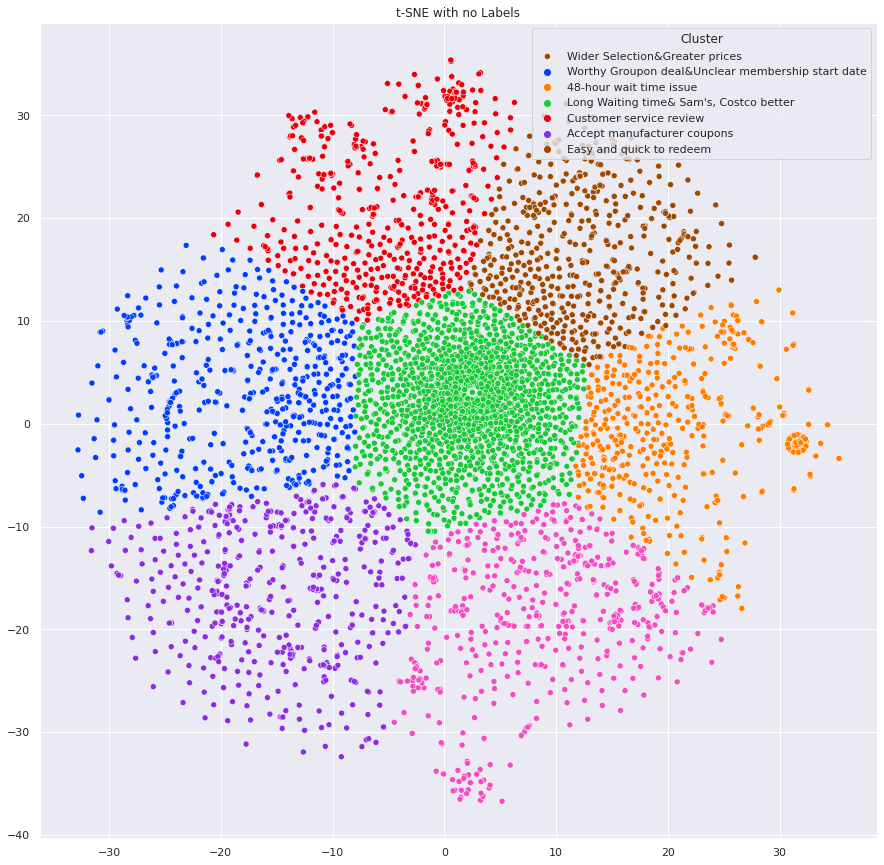

In [94]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# plot
g = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = y_pred, palette= 'bright')

plt.legend(title='Cluster', loc='upper right', labels=['Wider Selection&Greater prices', 'Worthy Groupon deal&Unclear membership start date','48-hour wait time issue',"Long Waiting time& Sam's, Costco better",'Customer service review','Accept manufacturer coupons','Easy and quick to redeem'])


plt.title('t-SNE with no Labels')
plt.show(g)

# Topic Modelling

### Function

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

def ngrams_and_topic_modeling(df,cluster,return_tfidf = False):
    ''' Here we are going to make a function that print out the topics and the ngrams 
        of a given model based on 
    '''
    # Here we are going to be initializing the vectorizers 
    tfidf_ngram = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
    tfidf_lda = TfidfVectorizer(max_features=50,stop_words='english')
    
    # Here we are going to be creating our df by review rating score 
    df_score = df.loc[df['clusters'] ==cluster,'without_stopwords']
    df_score_copy = df_score.copy(deep=True)
    
    df_score_transformed = tfidf_ngram.fit_transform(df_score)
    df_score_copy_transformed = tfidf_lda.fit_transform(df_score_copy)

    # getting ngrams and sorting in descending order
    tfidf_series = pd.Series(tfidf_ngram.vocabulary_)
    tfidf_series=tfidf_series.to_frame()
    tfidf_series['n-gram'] = tfidf_series.index
    tfidf_series.index = range(len(tfidf_series.index))
    tfidf_series.rename({0:'value_count'},axis=1,inplace=True)

    top_n_grams = tfidf_series.loc[~tfidf_series['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
    print('done with ngrams')
    print('starting lda...')
    # Next we are going to do the Topic Modelling.
#     search_params = {'n_components': list(range(3,8)), 'learning_decay': [.5, .7, .9],'random_state':[23]}
    lda = LatentDirichletAllocation(n_components=3,learning_decay=.5,random_state=23)
#     grid = GridSearchCV(lda,param_grid=search_params,n_jobs=3)
    
    lda.fit(df_score_copy_transformed)
    
    tfidf_lda = pd.DataFrame(df_score_copy_transformed.toarray(),columns=tfidf_lda.get_feature_names())
    topics = display_topics(lda,tfidf_lda.columns,10)
    
    return top_n_grams , topics


def preprocessing_text(df):
    '''
    Here we are going to clean the text to be in a good format for further analysis 
    
    input: df ; DataFrame object that contains all of the reviews. 
    '''  
    lemm = WordNetLemmatizer()
    df = df.loc[~df.caption.isnull()] # here we are going to only process reviews 
    
    df.caption =  df.caption.apply(lambda review: clean_translated_reviews(review) if 'Google' in review else review)
        
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(str.lower)
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: re.sub(r'[^\w\s]','',review)) # removes punctuation
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: re.sub('\([^()]*\)','',review)) # removes words within parenthesis 
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: emoji_pattern.sub(r'', review)) 
    df.loc[:,'caption_split'] = df.loc[:,'caption'].apply(lambda review: review.split(' '))
    
    clean_reviews = []
    for review_idx , review in df.caption_split.items():
        temp = []
        for idx, word in enumerate(review):
            if word in stop_words:
                continue
            else:
                temp.append(lemm.lemmatize(word))
        
        review_  = ' '.join(temp)
        clean_reviews.append(review_)
    
    df.loc[:,'caption'] = clean_reviews
    #df.drop(['Unnamed: 0'],axis=1,inplace=True)
    

    return df

## **Topic 1-7**

In [ ]:
bjs.rename(columns={'text':'caption'},inplace=True)
bjs = preprocessing_text(bjs)

#### **TOPIC 1**
1. Wider selection of items
2. Great prices

**Sample reviews**
- "The lady at customer service was very friendly and thanked me for joining BJ's. I actually have a membership at Sam's as well but I like BJ's much better because of a wider selection of items." - Patricia
- "Great price for membership, easy to sign up and BJ’s has great prices and friendly staff!!!" --- Kelly

In [ ]:
ngrams_bjs_0, topics_0 = ngrams_and_topic_modeling(bjs, cluster = 0)
topics_0

In [ ]:
ngrams_bjs_0

#### **TOPIC 2**
1. Groupon deal of BJ's is worthy
2. The membership start date is unclear 

**Example reviews:**
- "It was a great deal. A year membership and a 25.00 gift card. It was like getting a year membership for $10.00"
- "BJs is not honoring membership start date from when we actually sign up for membership. It starts the membership when we bought the Groupon, which is absurd as I will lose 2-3 months of membership as I redeemed my Groupon sometime in March. I will never recommend BJs to anyone due to this fraud."
- "I would warn people who purchase this that the membership starts once you pay for the groupon and not when you redeem the voucher in the store. The information was very sketchy and the date the groupon expiration date on the groupon only reflects the promotional value expiration date. I brought this in December but did not redeem or activate the membership..."

In [ ]:
ngrams_bjs_1, topics_1 = ngrams_and_topic_modeling(bjs, cluster = 1)
topics_1

In [ ]:
ngrams_bjs_1

### **TOPIC 3**
1. Wait 48 hours after redeeming before activating the membership
**Sample reviews**
- "Read the fine print for this Groupon. You have to wait 48 hours to use it. For this year a $25 membership is worth it for me, because the BJ's in DE sell gas and propane. I have been a Costco member for years, and after doing comparison shopping, I still prefer Costco. Thus far, Costco offers better products and prices. Additionally, Costco has more organic and gluten free products." --- Jenifer
- "The customer service was terrible. The membership associate rudely explained to us that we would have to wait 48 hours after redeeming the Groupon voucher before we could use the membership. We also had to wait approximately 10 minutes in line." --- Rachel


In [ ]:
ngrams_bjs_2, topics_2 = ngrams_and_topic_modeling(bjs, cluster = 2)
topics_2

In [93]:
ngrams_bjs_2

,value_count,n-gram
25,49,went redeem groupon
10,48,went customer service
47,47,wait 48 hours
46,46,use groupon membership
22,45,told customer service
49,44,sams club membership
21,43,right away great
29,42,regular grocery store
36,41,redeeming groupon voucher
4,40,new membership card


### **TOPIC 4**
1. Long waiting line & customer service time
2. Prices higher than Sam's (93 reviews)
3. Like Costco better (29 reviews)
4. Good place to buy in bulk

**Sample reviews**
- "Very long waiting line to get my membership. They told me that my membership is valid from the date I got the Groupon not from the date I got the membership at BJs even though it states that on the Groupon website." --- Sania
- "Sams club has lower prices so they should lower to competitive price that they are a little expensive" --- Jackie
- "Always out of things that I need such as vegetables and fruit. Poor customer service at the desk. It's definitely not Costco!" --- Meryl
- "Enjoyed shopping there good buys on bulk items" --- Dorothy

In [ ]:
ngrams_bjs_3, topics_3 = ngrams_and_topic_modeling(bjs, cluster = 3)
topics_3

In [ ]:
ngrams_bjs_3

### **TOPIC 5**
1. Customer service reviews (Negative: 191 | Positive: 737)

**Sample reviews**
- "Friendly staff and amazing service!"  --- Tim
- "Poor customer service. No check out assistance. Only 1 person on duty for checking out at Christmas. Very bad." --- Gayle
- "This Groupon states that a $55 coupon book is included, but I did not receive it. The customer service at the membership desk was poor. The representative did not speak to me the whole time I was there. He just handed me my card when he was done. When I said thank you he didn't respond. I gave it a three because the selection and prices in the store are good." --- Karen

In [ ]:
ngrams_bjs_4, topics_4 = ngrams_and_topic_modeling(bjs, cluster = 4)
topics_4

In [ ]:
ngrams_bjs_4

In [ ]:
# Measure negative reviews
neg_review_4 = ngrams_bjs_4[ngrams_bjs_4['n-gram'].str.contains("worst|terrible|poor|slow")]
print("Negative review count: "+ str(neg_review_4.value_count.sum()))

In [ ]:
# Measure positive reviews
pos_review_4 = ngrams_bjs_4[ngrams_bjs_4['n-gram'].str.contains("good|friendly|great|helpful|care|wonderful")]
print("Positive review count: "+ str(pos_review_4.value_count.sum()))

### **TOPIC 6**
1. Accept manufacture coupon is a highlight
2. Coupons saved a lot of money

**Sample Reviews**
- "We love BJ's. they have more brands that we use, & accept manufacturer coupons." --- Stacy
- "Always check out their coupons, I usually find a couple to help save some money." --- Patricia

In [ ]:
ngrams_bjs_5, topics_5 = ngrams_and_topic_modeling(bjs, cluster = 5)
topics_5

In [ ]:
ngrams_bjs_5

#### **TOPIC 7**
- BJ's Groupons are easy to use and quick to redeem

**Sample reviews**
- "Easy to use my Groupon! Lots of great things at BJ's from discount gas to food buying in bulk! And many other great things as well. Definitely 👍!" --- Doris
- "It was very easy to redeem my Groupon voucher. Great deal." --- Kelly

In [ ]:
ngrams_bjs_6, topics_6 = ngrams_and_topic_modeling(bjs, cluster = 6)
topics_6

In [ ]:
ngrams_bjs_6